In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# !pip install seaborn

In [197]:
def pd_xand(a, b):
    return (a & b) | (~a & ~b)
    
def score_calibration(df):
    # margin is score diff
    df["margin"] = df["scores"] - df["reference_scores"]

    # our negative range doesn't seem to go as low as positive goes high
    # maybe we should cut off our max margin at 99.5% quantile
    margin_max = df['margin'].quantile(0.995) 
    # margin_max = df['margin'].max()
    margin_max_rounded = np.round(margin_max * 2) / 2
    # print(type(margin_upper))
    print(f"high {margin_max_rounded}")
    interval_tuples = [(i, i+0.5) for i in np.arange(0, margin_max_rounded, 0.5)]
    bins = pd.IntervalIndex.from_tuples(interval_tuples)
    df['margin_bins'] = pd.cut(df['margin'].abs(), bins)
    df['accuracy'] = pd_xand((df["preferred"] == "ours"), (df["margin"] > 0)).astype(float)

    margin_df = df.groupby('margin_bins')['accuracy'].mean()
    margin_df = margin_df.reset_index()
    margin_df["middle"] = margin_df['margin_bins'].apply(lambda x: x.mid)

    return margin_df

def plot_model_calibration(model_name, color):
    SEEDS = [44413, 55513, 66613, 77713]
    margin_dfs = []
    for seed in SEEDS:
        eval_fname = f"eval/sampled_data/refactor-chosen-rejected3/ppo_left_padding/{model}/{seed}/query_responses_gpt-3.5-turbo-0125.csv"
        margin_dfs.append(score_calibration(pd.read_csv(eval_fname)))
    
    sns.lineplot(data=pd.concat(margin_dfs), x="middle", y="accuracy", estimator="mean", errorbar="sd", color=color)

high 9.5
high 7.5
high 11.0
high 8.5


ValueError: cannot reindex on an axis with duplicate labels

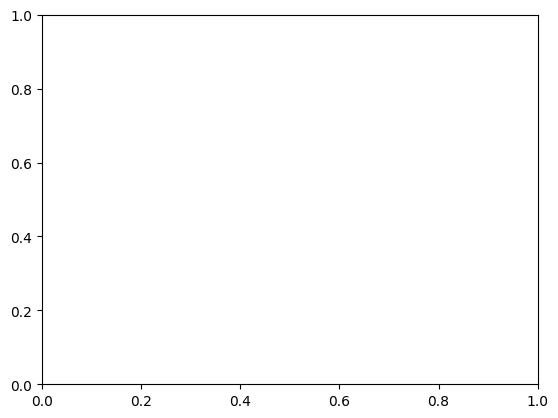

In [201]:

models = [
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
]
colors = ['#7ebdb4', '#2b8cbe', '#08306b']

# for model, color in zip(models, colors):
    
# plot_model_calibration(models[2], colors[2])
SEEDS = [44413, 55513, 66613, 77713]
margin_dfs = []
for seed in SEEDS:
    eval_fname = f"eval/sampled_data/refactor-chosen-rejected3/ppo_left_padding/{model}/{seed}/query_responses_gpt-3.5-turbo-0125.csv"
    margin_dfs.append(score_calibration(pd.read_csv(eval_fname)))

sns.lineplot(data=pd.concat(margin_dfs), x="middle", y="accuracy", estimator="mean", errorbar="sd", color=colors[2])

In [171]:
concat_df = pd.concat(margin_dfs)

<Axes: xlabel='middle', ylabel='accuracy'>

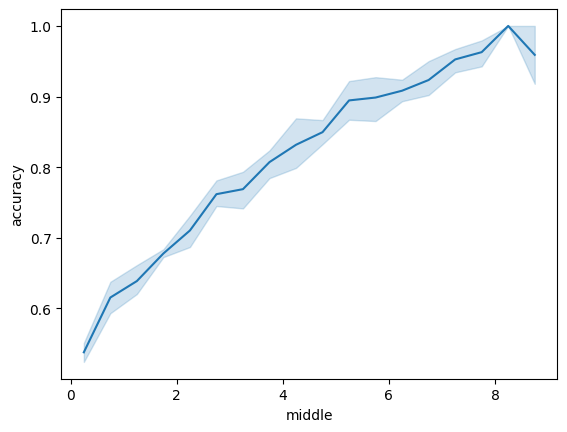

In [172]:
sns.lineplot(data=concat_df, x="middle", y="accuracy", estimator="mean")

In [148]:
perfect_calibration = margin_df["middle"].apply(lambda x: 1 / (1 + math.exp(-x)))

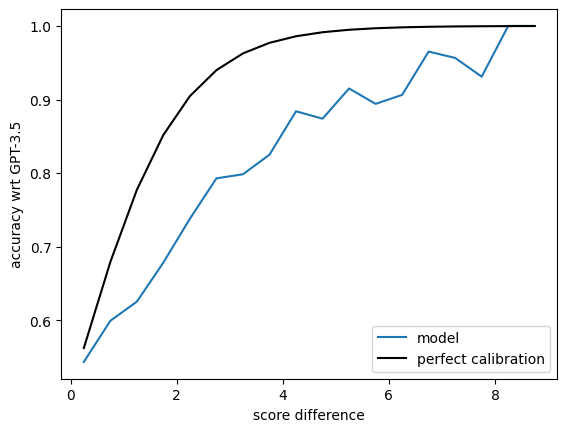

In [162]:
sns.lineplot(data=margin_df, x="middle", y="accuracy", label="model")
sns.lineplot(x=margin_df["middle"], y=perfect_calibration, color="black", label="perfect calibration")
plt.xlabel("score difference")
plt.ylabel("accuracy wrt GPT-3.5")
plt.gca().invert_yaxis()

In [143]:
margins = margin_df["middle"].to_numpy()

In [145]:
import math

In [147]:
sns.

0     0.562177
1     0.679179
2     0.777300
3     0.851953
4     0.904651
5     0.939913
6     0.962673
7     0.977023
8     0.985936
9     0.991423
10    0.994780
11    0.996827
12    0.998073
13    0.998830
14    0.999290
15    0.999569
16    0.999739
17    0.999842
Name: middle, dtype: category
Categories (18, float64): [0.562177 < 0.679179 < 0.777300 < 0.851953 ... 0.999290 < 0.999569 < 0.999739 < 0.999842]